## Day 21

https://adventofcode.com/2023/day/21

In [26]:
def readInput21(infile):
    with open(infile) as f:
        lines = f.read().strip().splitlines()
        grid = {}
        S = (-1,-1)
        for j,l in enumerate(lines):
            for i,v in enumerate(l):
                grid[(i,j)] = v
                if v=="S":
                    S = (i,j)
        return grid, S, len(lines), len(lines[0])

In [30]:
def part1(infile,nsteps = 6):
    grid, S, ymax, xmax = readInput21(infile)
    plots = {S}
    dirs = [(+1,0),(-1,0),(0,+1),(0,-1)]
    for _ in range(nsteps):
        plots_new = set()
        for x,y in plots:
            for dx,dy in dirs:
                P = (x+dx,y+dy)
                if P in grid.keys() and if grid[P]!="#":
                    plots_new.add(P)
        plots = plots_new
    return len(plots)

In [34]:
print("Test 1:",part1("examples/example21.txt",6))
print("Part 1:",part1("AOC2023inputs/input21.txt",64))

Test 1: 16
Part 1: 3729


### Part 2

Oh, an infinite grid! Like it's 2019 again ;-)

Observations:

* S is at the center of the grid in position (65,65)
* The grid dimension is 131x131
* The external border of the grid is empty (no obstacles)
* In 64 steps one can barely reach the border of the grid! If I remove the check `if P in grid.keys()` in my `part1()` solution I don;'t trigger any error (yet!), neither I do for 65 steps: the first out-of-grid positions arrive for 66 steps 
* Given the huge size of the requested number of steps for part 2, some extrapolation ust be possible!

In [29]:
grid, S, ymax, xmax = readInput21("AOC2023inputs/input21.txt")
print(xmax,ymax,S)

131 131 (65, 65)


* The requested number of steps (26501365) is suspicious (why not a large round number?)
* The number of requested steps ends with 65 (the number of steps) triggering the first our-of-grid positions
* If I remove the first 65 steps, the remaining are steps are a multiple of the grid size:

In [39]:
(26501365-65)/131

202300.0

* Where are the first out-of-grid positions?
    * They are in the middle of the external borders of the first "external" grids:
    * It makes sense: the movement is expanding as a romboid, modulo some positions that are not allowed because of the obstacles!

In [47]:
grid, S, ymax, xmax = readInput21("AOC2023inputs/input21.txt")
nsteps = 66
plots = {S}
dirs = [(+1,0),(-1,0),(0,+1),(0,-1)]
for _ in range(nsteps):
    plots_new = set()
    for x,y in plots:
        for dx,dy in dirs:
            P = (x+dx,y+dy)
            if P in grid.keys():
                if grid[P]!="#":
                    plots_new.add(P)
            else:
                print(P)
    plots = plots_new

(131, 65)
(-1, 65)
(65, 131)
(65, -1)


* The allowed position are indeed filling the space as an expanding romboid, with an alternating checkers pattern excluding all position where obstacles are found

* I can probably compute the plots just from the number of steps and the positions of the rocks

In [112]:
def evolve_grid(grid,start=(65,65),nsteps=65):
    plots = {start}
    dirs = [(+1,0),(-1,0),(0,+1),(0,-1)]
    for _ in range(nsteps):
        plots_new = set()
        for x,y in plots:
            for dx,dy in dirs:
                P = (x+dx,y+dy)
                if P in grid.keys():
                    if grid[P]!="#":
                        plots_new.add(P)
        plots = plots_new
    return plots

import matplotlib.pyplot as plt
import numpy as np

ROCK = 2
PLOT = 1

def fill_garden(plots,grid,ymax,xmax):
    garden = np.zeros((ymax,xmax))
    for (x,y),v in grid.items():
        if v=="#":
            garden[y,x] = ROCK
    for (x,y) in plots:
        garden[y,x] = PLOT
    return garden

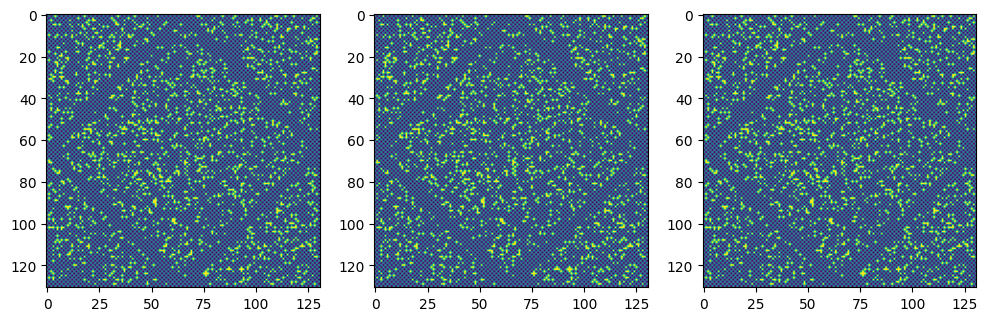

In [115]:
plots_1 = evolve_grid(grid,start=(65,65),nsteps=131+65)
plots_2 = evolve_grid(grid,start=(65,65),nsteps=2*131+65)
plots_3 = evolve_grid(grid,start=(65,65),nsteps=3*131+65)

garden_1 = fill_garden(plots_1,grid,ymax,xmax)
garden_2 = fill_garden(plots_2,grid,ymax,xmax)
garden_3 = fill_garden(plots_3,grid,ymax,xmax)

fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(garden_1)
axs[1].imshow(garden_2)
axs[2].imshow(garden_3)

In [116]:
len(plots_1), len(plots_2), len(plots_3)

(7623, 7558, 7623)

* Interestingly, the number of filled spots is different depending on the number of steps: this is because the grid size is odd (131), so the checker pattern will be different depending on whether number of steps is odd or even

* Let's imagine to make 131 steps: this corresponds to make 131 steps in a central grid, and 65 steps on 4 grids where the stating point is the out-of-grid position I get at the 66-th step of the central grid:

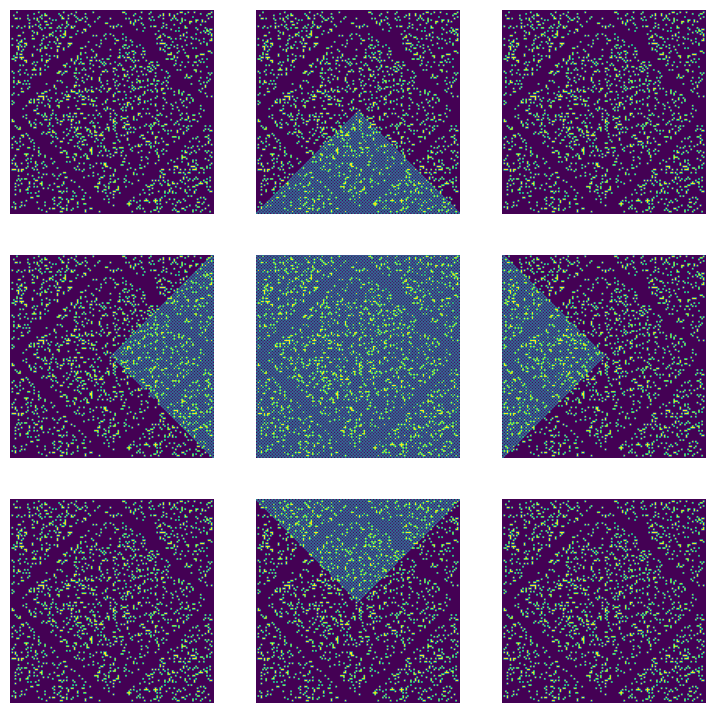

In [217]:
plots = {}

plots[( 0, 0)] = evolve_grid(grid,start=( 65, 65),nsteps=131)
plots[( 1, 0)] = evolve_grid(grid,start=(  0, 65),nsteps=65)
plots[(-1, 0)] = evolve_grid(grid,start=(130, 65),nsteps=65)
plots[( 0, 1)] = evolve_grid(grid,start=( 65, 0 ),nsteps=65)
plots[( 0,-1)] = evolve_grid(grid,start=( 65,130),nsteps=65)

plots[(-1,-1)] = []
plots[( 1, 1)] = []
plots[(-1, 1)] = []
plots[( 1,-1)] = []

gardens = {}
for (i,j),plot in plots.items():
    gardens[(i,j)] = fill_garden(plot,grid,ymax,xmax)
    
fig, axs = plt.subplots(3,3, figsize=(9,9))
xc,yc = 1,1

for ax in axs.flat:
     ax.axis('off') 

for (x,y),g in gardens.items():
    axs[yc+y,xc+x].imshow(g)

* The number of steps is a even number + 65 (26501365 = 131 * 202300 + 65 )
* I need to verify the configuration of plots for even and odd multiples of 131, and for 65, assuming different initial points:

In [340]:
gridsize = ymax # 131
halfgrid = gridsize//2 # 65
print(gridsize,halfgrid)

131 65


In [341]:
# fully filled grids
plots_oddsteps  = evolve_grid(grid,start=( 65, 65),nsteps=3*131) # center
plots_evensteps = evolve_grid(grid,start=( 65, 65),nsteps=2*131) # cross around center

In [342]:
# diamonds extremes
plots_corner_top = evolve_grid(grid,start=(  0, 65),nsteps=131-1)
plots_corner_bot = evolve_grid(grid,start=(130, 65),nsteps=131-1)
plots_corner_lef = evolve_grid(grid,start=( 65,  0),nsteps=131-1)
plots_corner_rig = evolve_grid(grid,start=( 65,130),nsteps=131-1)

In [343]:
# smaller lateral grids
plots_side_lef_bot_small = evolve_grid(grid,start=(130,  0),nsteps=65-1)
plots_side_rig_bot_small = evolve_grid(grid,start=(  0,  0),nsteps=65-1)
plots_side_lef_top_small = evolve_grid(grid,start=(130,130),nsteps=65-1)
plots_side_rig_top_small = evolve_grid(grid,start=(  0,130),nsteps=65-1)

In [377]:
# larger lateral grids
plots_side_lef_bot_big = evolve_grid(grid,start=(130,  0),nsteps=131+65-1)
plots_side_rig_bot_big = evolve_grid(grid,start=(  0,  0),nsteps=131+65-1)
plots_side_lef_top_big = evolve_grid(grid,start=(130,130),nsteps=131+65-1)
plots_side_rig_top_big = evolve_grid(grid,start=(  0,130),nsteps=131+65-1)

In [373]:
plots = {}

plots[(0,0)] = plots_oddsteps 

plots[( 1, 0)] = plots_evensteps
plots[(-1, 0)] = plots_evensteps
plots[( 0, 1)] = plots_evensteps
plots[( 0,-1)] = plots_evensteps

plots[( 2, 0)] = plots_corner_top
plots[(-2, 0)] = plots_corner_bot
plots[( 0, 2)] = plots_corner_lef
plots[( 0,-2)] = plots_corner_rig

plots[( -2, 1)] = plots_side_lef_bot_small
plots[( -1, 2)] = plots_side_lef_bot_small
plots[(  1, 2)] = plots_side_rig_bot_small 
plots[(  2, 1)] = plots_side_rig_bot_small

plots[(  -2, -1)] = plots_side_lef_top_small 
plots[(  -1, -2)] = plots_side_lef_top_small
plots[(   2, -1)] = plots_side_rig_top_small 
plots[(   1, -2)] = plots_side_rig_top_small

plots[(  -1, 1)] = plots_side_lef_bot_big
plots[(  -1,-1)] = plots_side_lef_top_big
plots[(   1, 1)] = plots_side_rig_bot_big
plots[(   1,-1)] = plots_side_rig_top_big

plots[( -2, 2)] = []
plots[(  2,-2)] = []
plots[(  2, 2)] = []
plots[( -2,-2)] = []

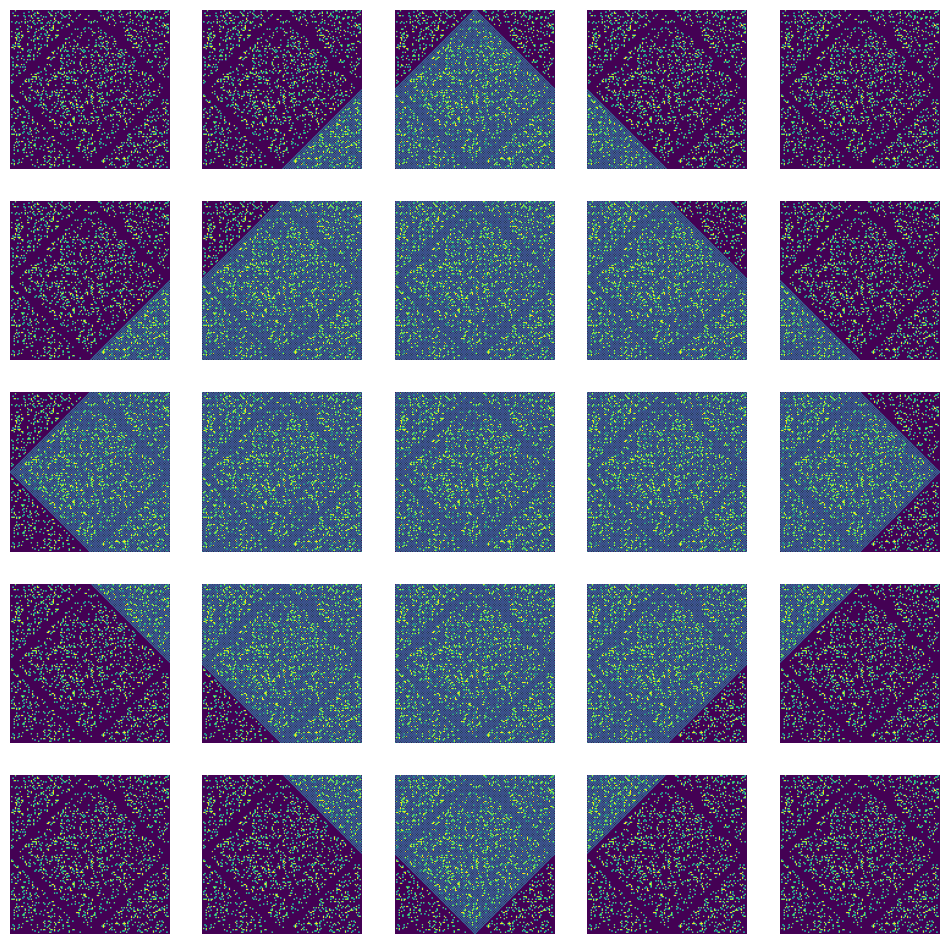

In [374]:
gardens = {}
for (i,j),plot in plots.items():
    gardens[(i,j)] = fill_garden(plot,grid,ymax,xmax)
    
for ax in axs.flat:
     ax.axis('off')

fig, axs = plt.subplots(5,5, figsize=(12,12))
xc,yc = 2,2

for ax in axs.flat:
     ax.axis('off') 

for (x,y),g in gardens.items():
    axs[yc+y,xc+x].imshow(g)

In [401]:
nsteps = 26501365

romboid_width = ( nsteps - 65 ) // 131

nfull_odd  =  ( romboid_width//2*2 - 1 ) ** 2
nfull_even =  ( romboid_width//2*2     ) ** 2

nodd = len(plots_oddsteps)
neven = len(plots_evensteps)

ncorners = len(plots_corner_top)+len(plots_corner_bot)+len(plots_corner_lef)+len(plots_corner_rig)
nsides_small = len(plots_side_lef_bot_small)+len(plots_side_rig_bot_small)+len(plots_side_lef_top_small)+len(plots_side_rig_top_small)
nsides_large = len(plots_side_lef_bot_big)  +len(plots_side_lef_top_big)  +len(plots_side_rig_bot_big)  +len(plots_side_rig_top_big)

total = nfull_odd*nodd + nfull_even*neven + romboid_width*nsides_small + (romboid_width-1)*nsides_large + ncorners

print("Total plots =",total)

Total plots = 621289922886149
